In [1]:
%pylab
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import os
import sqlalchemy as sql #create_engine
import photutils

In [3]:
from gPhoton import PhotonPipe
from gPhoton.MCUtils import angularSeparation, print_inline

In [4]:
import gfcat_utils as gfu

/Users/cm/Dropbox/gfcat/code/gfcat_utils.py:397: SyntaxWarning: "is" with a literal. Did you mean "=="?
  data_directory=data_directory, eclipse=eclipse, b="n" if band is "NUV" else "f"
/Users/cm/Dropbox/gfcat/code/gfcat_utils.py:549: SyntaxWarning: "is" with a literal. Did you mean "=="?
  data_directory=data_directory, eclipse=eclipse, b="n" if band is "NUV" else "f"
/Users/cm/Dropbox/gfcat/code/gfcat_utils.py:643: SyntaxWarning: "is" with a literal. Did you mean "=="?
  data_directory=data_directory, eclipse=eclipse, b="n" if band is "NUV" else "f"
/Users/cm/Dropbox/gfcat/code/gfcat_utils.py:771: SyntaxWarning: "is" with a literal. Did you mean "=="?
  data_directory=data_directory, eclipse=eclipse, b="n" if band is "NUV" else "f"
/Users/cm/Dropbox/gfcat/code/gfcat_utils.py:800: SyntaxWarning: "is" with a literal. Did you mean "=="?
  qadir + "/" + "{n}_{b}d.csv".format(n=n, b="n" if band is "NUV" else "f")
/Users/cm/Dropbox/gfcat/code/gfcat_utils.py:831: SyntaxWarning: "is" with a 

#### Query observation data for GJ65.

In [5]:
def query(query,catdbfile='catalog.db'):
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    out = engine.execute(query).fetchall()
    engine.dispose()
    return out

def conesearch(skypos,match_radius=0.005,catdbfile='catalog.db'):
    out = np.array(query(f"SELECT eclipse, id, ra, dec, xcenter, ycenter FROM gfcat WHERE ra >= {skypos[0]-match_radius} AND ra <={skypos[0]+match_radius} AND dec>= {skypos[1]-match_radius} AND dec<={skypos[1]+match_radius}"))
    dist_ix = np.where(angularSeparation(skypos[0],skypos[1],
                                         out[:,2],out[:,3])<=match_radius)
    return pd.DataFrame({'eclipse':np.array(out[:,0][dist_ix],dtype='int16'),
                         'id':np.array(out[:,1][dist_ix],dtype='int16'),
                         'ra':out[:,2][dist_ix],
                         'dec':out[:,3][dist_ix],
                         'xcenter':out[:,4][dist_ix],
                         'ycenter':out[:,5][dist_ix]})

%time uvceti = conesearch((24.76279, -17.94948)) # UV Ceti
print(f'There are {len(uvceti)} UV Ceti observations.')
print(f'We will use the first one: e{(eclipse:=int(uvceti.iloc[0].eclipse))}')

CPU times: user 6.56 ms, sys: 3.09 ms, total: 9.65 ms
Wall time: 18.4 ms
There are 9 UV Ceti observations.
We will use the first one: e13656


In [17]:
%time m31 = conesearch((10.683,41.27)) # M31
m31

CPU times: user 4.15 ms, sys: 1.33 ms, total: 5.48 ms
Wall time: 4.45 ms


,eclipse,id,ra,dec,xcenter,ycenter
0,23417,8993,10.678468,41.269385,1558.698742,1551.109416
1,29296,5968,10.678785,41.273504,1598.078247,1541.928888
2,7559,10299,10.678801,41.269801,708.092431,2633.995322
3,1903,9100,10.679172,41.269568,1590.081797,1673.041873
4,28468,3197,10.679757,41.271121,2716.031236,1410.469326
5,29296,5913,10.680282,41.269870,1595.376353,1533.207508
6,23418,8279,10.680677,41.270491,1590.872392,1544.013549
7,29306,7386,10.680759,41.270975,1553.904299,1612.574083
8,29311,2841,10.681495,41.270751,2631.774957,1323.487448
9,23418,8197,10.681540,41.267237,1589.316130,1536.203502


In [7]:
data_directory='data' # Relative path to the local disk location that data should be written
band = 'NUV'

#### Download the raw data from MAST

In [8]:
raw6file = gfu.download_raw6(eclipse,band,data_directory=data_directory)

data/e13656/e13656-nd-raw6.fits.gz already exists.
	Use keyword `force` to re-download.


#### Calibrate the data

In [9]:
photonfile = '{d}/e{e}/e{e}-{b}d.h5'.format(
        d=data_directory, e=eclipse, b='n' if band is 'NUV' else 'f') # output filename
if not os.path.exists(photonfile):
    PhotonPipe.photonpipe(raw6file.split('.')[0][:-5],band,raw6file=raw6file,verbose=2)

<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-9-d23366aee20b>:2: SyntaxWarning: "is" with a literal. Did you mean "=="?
  d=data_directory, e=eclipse, b='n' if band is 'NUV' else 'f') # output filename


In [10]:
events = gfu.calibrate_photons(photonfile,band)
xcalfilename = photonfile.replace('.h5','-xcal.h5')
if len(events):
    print('Writing {xcalfilename}'.format(xcalfilename=xcalfilename))
    with pd.HDFStore(xcalfilename) as store:
        store.append('events',events)
else:
    raise('There is no valid data in this visit and everything after will fail.')

Writing data/e13656/e13656-nd-xcal.h5


#### Create full-depth images and 120s movies

In [11]:
gfu.make_images(eclipse,band,data_directory=data_directory)

NUV images already exist for e13656.


Opened data/e13656/e13656-nd-cnt.fits.gz
	Parsed file header.
	Retrieved flag and edge maps.


<ipython-input-12-84d9e2391867>:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(cntmap), cmap="Greys", origin="lower")
<ipython-input-12-84d9e2391867>:7: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(edgemap), origin="lower", cmap="cool") # "edge" events are blueish
<ipython-input-12-84d9e2391867>:8: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(flagmap), origin="lower", cmap="Wistia") # "hotspot" events are yellowish


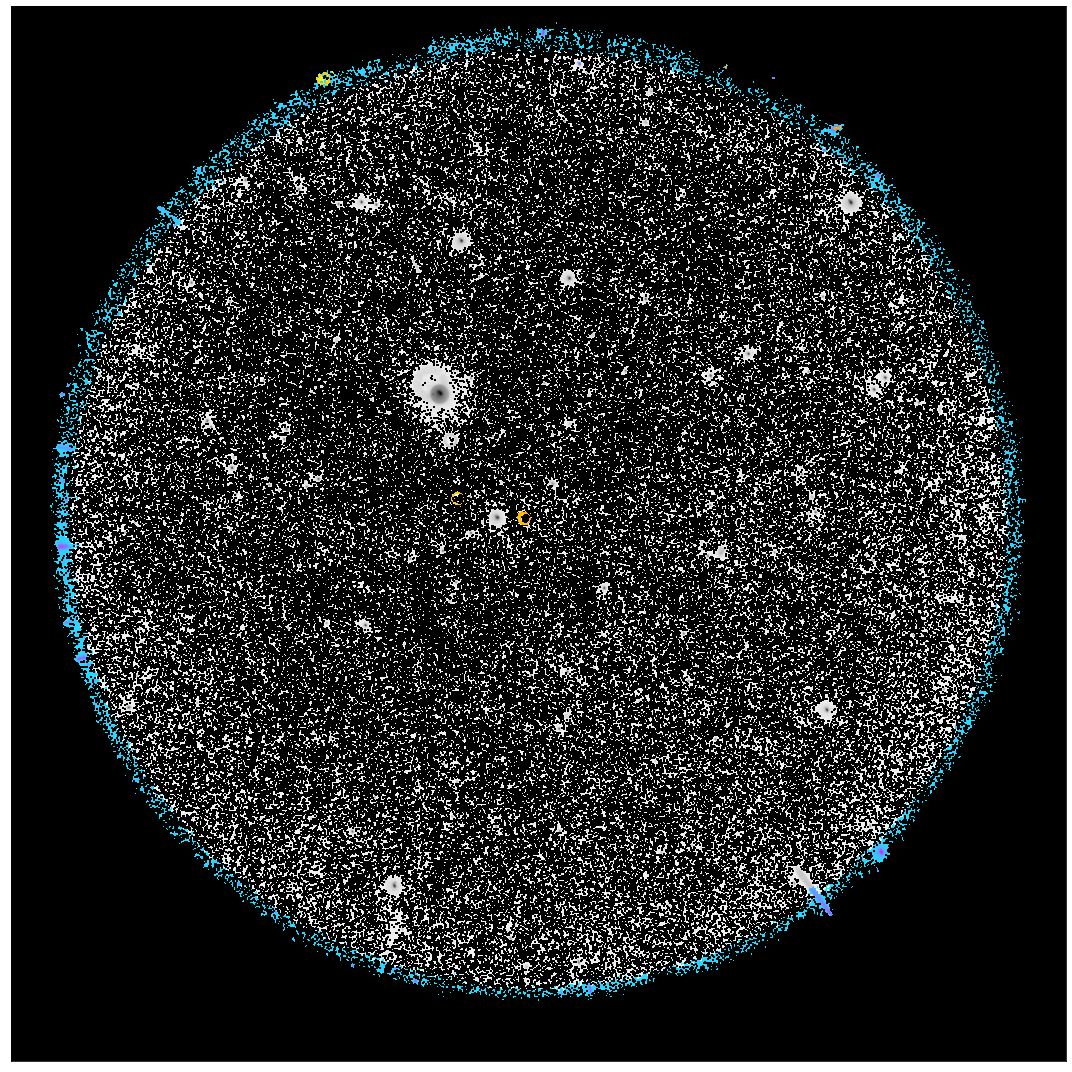

In [12]:
cntfilename = photonfile.replace(".h5", "-cnt.fits.gz")
moviefilename = photonfile.replace(".h5", "-mov.fits") # Not used here
cntmap, flagmap, edgemap, wcs, tranges, exptimes = gfu.read_image(cntfilename)
plt.figure(figsize=(15, 15))
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r")
plt.imshow(np.log10(cntmap), cmap="Greys", origin="lower")
plt.imshow(np.log10(edgemap), origin="lower", cmap="cool") # "edge" events are blueish
plt.imshow(np.log10(flagmap), origin="lower", cmap="Wistia") # "hotspot" events are yellowish
plt.xticks([])
plt.yticks([])
plt.tight_layout()

#### Generate an image stamp of the target source

<ipython-input-13-37062652de1d>:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(cntmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Greys_r')
<ipython-input-13-37062652de1d>:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(edgemap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='cool')
<ipython-input-13-37062652de1d>:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(flagmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Wistia')


([], [])

/Users/cm/opt/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/cm/opt/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/cm/opt/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/cm/opt/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([self.norm.vmin, self.norm.vmax],


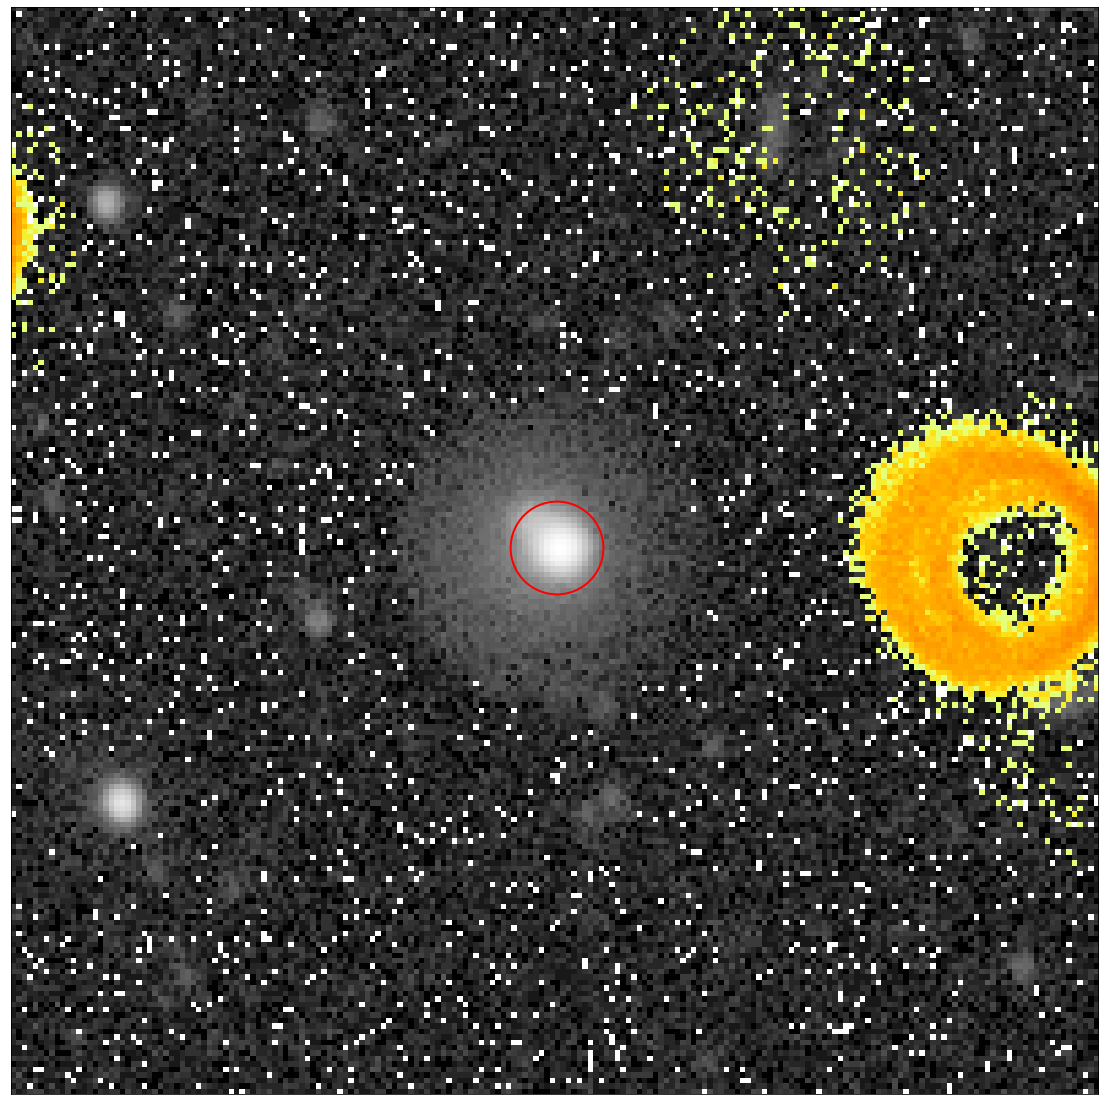

In [13]:
sz = 100 # half height / width of stamp in pixels
x,y = int(np.round(uvceti.iloc[0].xcenter)),int(np.round(uvceti.iloc[0].ycenter))
plt.figure(figsize=(20, 20))
plt.imshow(np.log10(cntmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Greys_r')
plt.imshow(np.log10(edgemap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='cool')
plt.imshow(np.log10(flagmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Wistia')
# Now overplot the aperture
photutils.CircularAperture([sz,sz], r=8.533333333333326).plot(color='red', lw=2, alpha=1)
plt.xticks([])
plt.yticks([])